In [1]:
from qboard import Solver

%matplotlib inline
from pyqubo import Array, Placeholder, Constraint
from pyqubo import Spin

# useful additional packages
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import numpy as np
import networkx as nx
import retworkx as rx

In [2]:
mode = "remote:simcim"
#mode = "remote:dwave"

# Access parameters
PARAMS = {
"remote_addr": "https://remote.qboard.tech", 
"access_key": "b229d784-53e5-41e0-98c3-0aeea3c76a51"
}

# Solver initialization
s = Solver(mode="remote:gurobi", params=PARAMS) 

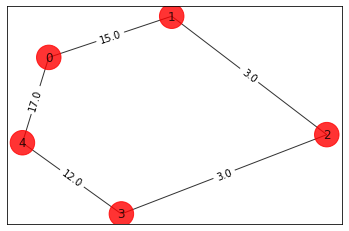

In [3]:
n=5 # Количество вершин
# Создаем граф:
G=nx.Graph()
G.add_nodes_from(np.arange(0,n,1))

# Список вершин графа, где (вершина1, вершина2, время пути между вершинами):
elist=[(0,1,15.0),(1,2,3.0),(2,3,3.0),(3,4,12.0),(4,0,17.0)]
# Заполняем граф:
G.add_weighted_edges_from(elist)

# Рисуем граф:
colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

draw_graph(G, colors, pos)

In [4]:
# Создаем матрицу смежности:
w = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i,j,default=0)
        if temp != 0:
            w[i,j] = temp['weight']
print(w)

[[ 0. 15.  0.  0. 17.]
 [15.  0.  3.  0.  0.]
 [ 0.  3.  0.  3.  0.]
 [ 0.  0.  3.  0. 12.]
 [17.  0.  0. 12.  0.]]


In [5]:
# Расчёт без квантового компьютера
best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i,j]*x[i]*(1-x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    print('case = ' + str(x)+ ' cost = ' + str(cost))

print('\nBest solution = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute))

case = [0, 0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0, 0] cost = 32.0
case = [0, 1, 0, 0, 0] cost = 18.0
case = [1, 1, 0, 0, 0] cost = 20.0
case = [0, 0, 1, 0, 0] cost = 6.0
case = [1, 0, 1, 0, 0] cost = 38.0
case = [0, 1, 1, 0, 0] cost = 18.0
case = [1, 1, 1, 0, 0] cost = 20.0
case = [0, 0, 0, 1, 0] cost = 15.0
case = [1, 0, 0, 1, 0] cost = 47.0
case = [0, 1, 0, 1, 0] cost = 33.0
case = [1, 1, 0, 1, 0] cost = 35.0
case = [0, 0, 1, 1, 0] cost = 15.0
case = [1, 0, 1, 1, 0] cost = 47.0
case = [0, 1, 1, 1, 0] cost = 27.0
case = [1, 1, 1, 1, 0] cost = 29.0
case = [0, 0, 0, 0, 1] cost = 29.0
case = [1, 0, 0, 0, 1] cost = 27.0
case = [0, 1, 0, 0, 1] cost = 47.0
case = [1, 1, 0, 0, 1] cost = 15.0
case = [0, 0, 1, 0, 1] cost = 35.0
case = [1, 0, 1, 0, 1] cost = 33.0
case = [0, 1, 1, 0, 1] cost = 47.0
case = [1, 1, 1, 0, 1] cost = 15.0
case = [0, 0, 0, 1, 1] cost = 20.0
case = [1, 0, 0, 1, 1] cost = 18.0
case = [0, 1, 0, 1, 1] cost = 38.0
case = [1, 1, 0, 1, 1] cost = 6.0
case = [0, 0, 1, 1, 1] 

In [6]:
# QUBO matrix definition
Q =[(0,1,0,0,1,1,750,0,0,750,1,0,0,0,0,1,0,0,0,0,1,850,0,0,850),
(1,0,1,0,0,750,1,750,0,0,0,1,0,0,0,0,1,0,0,0,850,1,850,0,0),
(0,1,0,1,0,0,750,1,750,0,0,0,1,0,0,0,0,1,0,0,0,850,1,850,0),
(0,0,1,0,1,0,0,750,1,750,0,0,0,1,0,0,0,0,1,0,0,0,850,1,850),
(1,0,0,1,0,750,0,0,750,1,0,0,0,0,1,0,0,0,0,1,850,0,0,850,1),
(1,750,0,0,750,0,1,0,0,1,1,150,0,0,150,1,0,0,0,0,1,0,0,0,0),
(750,1,750,0,0,1,0,1,0,0,150,1,150,0,0,0,1,0,0,0,0,1,0,0,0),
(0,750,1,750,0,0,1,0,1,0,0,150,1,150,0,0,0,1,0,0,0,0,1,0,0),
(0,0,750,1,750,0,0,1,0,1,0,0,150,1,150,0,0,0,1,0,0,0,0,1,0),
(750,0,0,750,1,1,0,0,1,0,150,0,0,150,1,0,0,0,0,1,0,0,0,0,1),
(0,0,0,0,0,1,850,0,0,850,0,1,0,0,1,1,150,0,0,150,1,0,0,0,0),
(0,0,0,0,0,850,1,850,0,0,1,0,1,0,0,150,1,150,0,0,0,1,0,0,0),
(0,0,0,0,0,0,850,1,850,0,0,1,0,1,0,0,150,1,150,0,0,0,1,0,0),
(0,0,0,0,0,0,0,850,1,850,0,0,1,0,1,0,0,150,1,150,0,0,0,1,0),
(0,0,0,0,0,850,0,0,850,1,1,0,0,1,0,150,0,0,150,1,0,0,0,0,1),
(0,0,0,0,0,0,0,0,0,0,1,150,0,0,150,0,1,0,0,1,1,600,0,0,600),
(0,0,0,0,0,0,0,0,0,0,150,1,150,0,0,1,0,1,0,0,600,1,600,0,0),
(0,0,0,0,0,0,0,0,0,0,0,150,1,150,0,0,1,0,1,0,0,600,1,600,0),
(0,0,0,0,0,0,0,0,0,0,0,0,150,1,150,0,0,1,0,1,0,0,600,1,600),
(0,0,0,0,0,0,0,0,0,0,150,0,0,150,1,1,0,0,1,0,600,0,0,600,1),
(1,850,0,0,850,0,0,0,0,0,0,0,0,0,0,1,600,0,0,600,0,1,0,0,1),
(850,1,850,0,0,0,0,0,0,0,0,0,0,0,0,600,1,600,0,0,1,0,1,0,0),
(0,850,1,850,0,0,0,0,0,0,0,0,0,0,0,0,600,1,600,0,0,1,0,1,0),
(0,0,850,1,850,0,0,0,0,0,0,0,0,0,0,0,0,600,1,600,0,0,1,0,1),
(850,0,0,850,1,0,0,0,0,0,0,0,0,0,0,600,0,0,600,1,1,0,0,1,0)]

#Q = bqm 
#print('QUBO-матрица:',Q)

# Getting results
spins, energy = s.solve_qubo(Q, timeout=30)
print(spins)

[2021-10-24 16:52:57] Found solution in cache 0.0
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
